In [1]:
from pathlib import Path
from matplotlib import pyplot as plt
import pandas as pd
import polars as pl
from scipy import stats
import seaborn as sns


# before_spearmanr_f: Path = Path('/mnt/eqa/zhangyuanfeng/methylation/best_pipeline/data/evalutaed/before/c_spearmanr/spearmanr_curated_features')
# after_spearmanr_f: Path = Path('/mnt/eqa/zhangyuanfeng/methylation/best_pipeline/data/evalutaed/after/c_spearmanr/spearmanr_curated_features')

before_spearmanr_f: Path = Path('/mnt/eqa/zhangyuanfeng/methylation/data_for_plot/6_methcali/before_spearmanr.csv')
after_spearmanr_f: Path = Path('/mnt/eqa/zhangyuanfeng/methylation/data_for_plot/6_methcali/after_spearmanr.csv')

In [2]:
df: pl.DataFrame = (pl.concat([pl.scan_csv(f)
                                 .unique(subset=['lab', 'label', 'feature', 'fgroup'],
                                         keep='first')
                                 .filter(pl.col('feature') == 'global')
                                 .with_columns(pl.lit(n).alias('treatment'))
                               for f, n in zip([before_spearmanr_f, after_spearmanr_f],
                                               ['before', 'after'])])
                      .collect())
df

lab,label,feature,fgroup,count,spearmanr,treatment
str,str,str,str,i64,f64,str
"""RR1""","""D6""","""global""","""global""",8693900,0.842051,"""before"""
"""PS2""","""F7""","""global""","""global""",55716840,0.792212,"""before"""
"""EM3""","""M8""","""global""","""global""",57350099,0.909357,"""before"""
"""EM4""","""M8""","""global""","""global""",57465392,0.876665,"""before"""
"""PS2""","""D6""","""global""","""global""",55055046,0.783259,"""before"""
…,…,…,…,…,…,…
"""BS2""","""T4""","""global""","""global""",57612028,0.872326,"""after"""
"""BS4""","""T1""","""global""","""global""",47455185,0.649092,"""after"""
"""RR1""","""BC""","""global""","""global""",8739303,0.859171,"""after"""


In [3]:
df_pivot: pl.DataFrame = (df.pivot(on='treatment',
                                   index=['lab', 'label'],
                                   values='spearmanr')
                            .with_columns((pl.col('after') - pl.col('before')).alias('diff')))
df_pivot

lab,label,before,after,diff
str,str,f64,f64,f64
"""RR1""","""D6""",0.842051,0.891551,0.049501
"""PS2""","""F7""",0.792212,0.807043,0.014831
"""EM3""","""M8""",0.909357,0.923009,0.013653
"""EM4""","""M8""",0.876665,0.892077,0.015412
"""PS2""","""D6""",0.783259,0.798943,0.015684
…,…,…,…,…
"""BS4""","""T2""",0.605068,0.646924,0.041855
"""EM4""","""T3""",0.871139,0.886077,0.014938
"""PS2""","""M8""",0.830973,0.845633,0.014661


In [4]:
def run_paired_test(before: pl.Series,
                    after: pl.Series,
                    alpha: float = .05):
    diff: pl.Series = (before - after).alias('diff')

    # Normality Test
    shapiro_stat, shapiro_p = stats.shapiro(diff)

    print(f'Shapiro-Wilk Normality Test: W={shapiro_stat:.3f}, p={shapiro_p:.3f}')
    if shapiro_p > 0.05:
        print('✅ Normality Test passed. t test can be used.')
        t_stat, p_val = stats.ttest_rel(after, before)
        print(f'\n👉 t test result:')
        print(f'  t = {t_stat:.3f}, samples = {diff.shape[0]}, p = {p_val:.3e}')
        print(f'  average diff = {diff.mean():.3f}')
        test_type = 't test'
        avg_diff = diff.mean()
    else:
        print('❌ Normality Test failed. Wilcoxon test will be used.')
        w_stat, p_val = stats.wilcoxon(before, after)
        print(f'\n👉 Wilcoxon test result:')
        print(f'  W = {w_stat:.0f}, p = {p_val:.3e}')
        print(f'  median diff = {diff.median():.3f}')
        print(f'  average diff = {diff.mean():.3f}')
        test_type = 'Wilcoxon'
        avg_diff = diff.median()

    change_pct = (after.mean() - before.mean()) / before.mean() * 100

    if p_val < alpha:
        print('✅ There is a significant difference between before and after treatment (p < 0.05)')
    else:
        print('❌ There is no significant difference between before and after treatment (p ≥ 0.05)')

    significant: bool = True if p_val < alpha else False

    return avg_diff, change_pct, test_type, p_val

In [8]:
run_paired_test(before=df_pivot['after'],
                after=df_pivot['before'])

Shapiro-Wilk Normality Test: W=0.708, p=0.000
❌ Normality Test failed. Wilcoxon test will be used.

👉 Wilcoxon test result:
  W = 0, p = 1.972e-21
  median diff = 0.015
  average diff = 0.022
✅ There is a significant difference between before and after treatment (p < 0.05)


(0.015119114022945468, -2.5668009331560513, 'Wilcoxon', 1.9719517121524354e-21)

In [5]:
label_test_results = []
for label in ['BC', 'BL', 'D5', 'D6', 'F7', 'M8', 'T1', 'T2', 'T3', 'T4']:
    print('-' * 50)
    print(f'Label: {label}')
    (avg_diff,
     change_pct,
     test_type,
     p_val) = run_paired_test(before=df_pivot.filter(pl.col('label') == label)['before'],
                              after=df_pivot.filter(pl.col('label') == label)['after'])
    label_test_results.append({
        'label': label, 'Average Diff': avg_diff,
        'Average Diff Change (%)': change_pct,
        'Test Type': test_type, 'p value': p_val
    })
label_test_results_df = pd.DataFrame(label_test_results)

--------------------------------------------------
Label: BC
Shapiro-Wilk Normality Test: W=0.905, p=0.183
✅ Normality Test passed. t test can be used.

👉 t test result:
  t = 5.034, samples = 12, p = 3.813e-04
  average diff = -0.037
✅ There is a significant difference between before and after treatment (p < 0.05)
--------------------------------------------------
Label: BL
Shapiro-Wilk Normality Test: W=0.818, p=0.015
❌ Normality Test failed. Wilcoxon test will be used.

👉 Wilcoxon test result:
  W = 0, p = 4.883e-04
  median diff = -0.014
  average diff = -0.015
✅ There is a significant difference between before and after treatment (p < 0.05)
--------------------------------------------------
Label: D5
Shapiro-Wilk Normality Test: W=0.660, p=0.000
❌ Normality Test failed. Wilcoxon test will be used.

👉 Wilcoxon test result:
  W = 0, p = 4.883e-04
  median diff = -0.015
  average diff = -0.021
✅ There is a significant difference between before and after treatment (p < 0.05)
---------

In [6]:
label_test_results_df

,label,Average Diff,Average Diff Change (%),Test Type,p value
0,BC,-0.037465,5.105648,t test,0.000381
1,BL,-0.014403,1.745136,Wilcoxon,0.000488
2,D5,-0.014907,2.478396,Wilcoxon,0.000488
3,D6,-0.015383,2.582101,Wilcoxon,0.000488
4,F7,-0.016838,2.781254,Wilcoxon,0.000488
5,M8,-0.014538,2.220879,Wilcoxon,0.000488
6,T1,-0.015224,2.438214,Wilcoxon,0.000488
7,T2,-0.014456,2.374319,Wilcoxon,0.000488
8,T3,-0.014886,2.537548,Wilcoxon,0.000488
9,T4,-0.015392,2.418214,Wilcoxon,0.000488


In [10]:
label_test_results_df.to_csv(
    '/mnt/eqa/zhangyuanfeng/methylation/data_for_plot/6_methcali/spearmanr_label_test_result.csv',
    index=False
)

In [8]:
lab_test_results = []
for lab in ['BS1', 'BS2', 'BS3', 'BS4', 'EM1', 'EM2',
            'EM3', 'EM4', 'PS1', 'PS2', 'PS3', 'RR1']:
    print('-' * 50)
    print(f'Label: {lab}')
    (avg_diff,
     change_pct,
     test_type,
     p_val) = run_paired_test(before=df_pivot.filter(pl.col('lab') == lab)['before'],
                              after=df_pivot.filter(pl.col('lab') == lab)['after'])
    lab_test_results.append({
        'lab': lab, 'Average Diff': avg_diff,
        'Average Diff Change (%)': change_pct,
        'Test Type': test_type, 'p value': p_val
    })
lab_test_results_df = pd.DataFrame(lab_test_results)

--------------------------------------------------
Label: BS1
Shapiro-Wilk Normality Test: W=0.756, p=0.004
❌ Normality Test failed. Wilcoxon test will be used.

👉 Wilcoxon test result:
  W = 0, p = 1.953e-03
  median diff = -0.011
  average diff = -0.010
✅ There is a significant difference between before and after treatment (p < 0.05)
--------------------------------------------------
Label: BS2
Shapiro-Wilk Normality Test: W=0.786, p=0.010
❌ Normality Test failed. Wilcoxon test will be used.

👉 Wilcoxon test result:
  W = 0, p = 1.953e-03
  median diff = -0.016
  average diff = -0.017
✅ There is a significant difference between before and after treatment (p < 0.05)
--------------------------------------------------
Label: BS3
Shapiro-Wilk Normality Test: W=0.863, p=0.082
✅ Normality Test passed. t test can be used.

👉 t test result:
  t = 17.958, samples = 10, p = 2.342e-08
  average diff = -0.012
✅ There is a significant difference between before and after treatment (p < 0.05)
-----

In [9]:
lab_test_results_df

,lab,Average Diff,Average Diff Change (%),Test Type,p value
0,BS1,-0.011404,1.343595,Wilcoxon,1.953125e-03
1,BS2,-0.016049,1.947095,Wilcoxon,1.953125e-03
2,BS3,-0.012438,1.524392,t test,2.342138e-08
3,BS4,-0.043333,7.003126,Wilcoxon,1.953125e-03
4,EM1,-0.012788,1.545364,t test,7.760538e-06
5,EM2,-0.014821,1.711502,Wilcoxon,1.953125e-03
6,EM3,-0.013727,2.125973,Wilcoxon,1.953125e-03
7,EM4,-0.014916,1.846239,Wilcoxon,1.953125e-03
8,PS1,-0.015831,2.530798,Wilcoxon,1.953125e-03
9,PS2,-0.014780,2.414888,Wilcoxon,1.953125e-03


In [11]:
lab_test_results_df.to_csv(
    '/mnt/eqa/zhangyuanfeng/methylation/data_for_plot/6_methcali/spearmanr_lab_test_result.csv',
    index=False
)

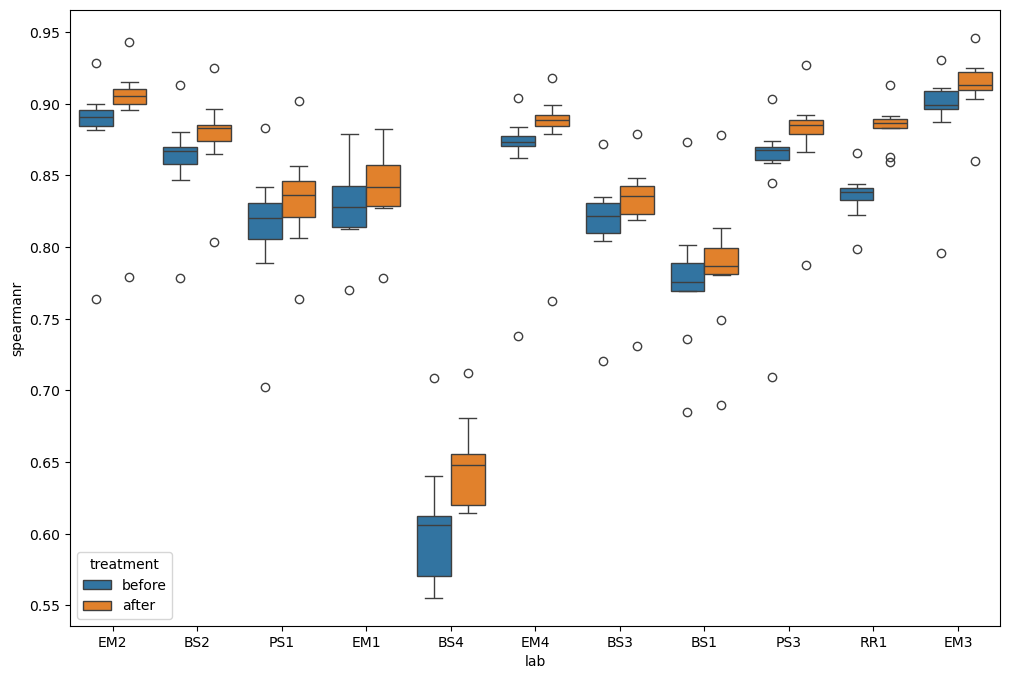

In [9]:
from matplotlib.axes import Axes
from matplotlib.figure import Figure

fig: Figure = plt.figure(figsize=(12, 8))
ax: Axes = (sns.boxplot(data=df.to_pandas(),
                        x='lab', y='spearmanr', hue='treatment'))

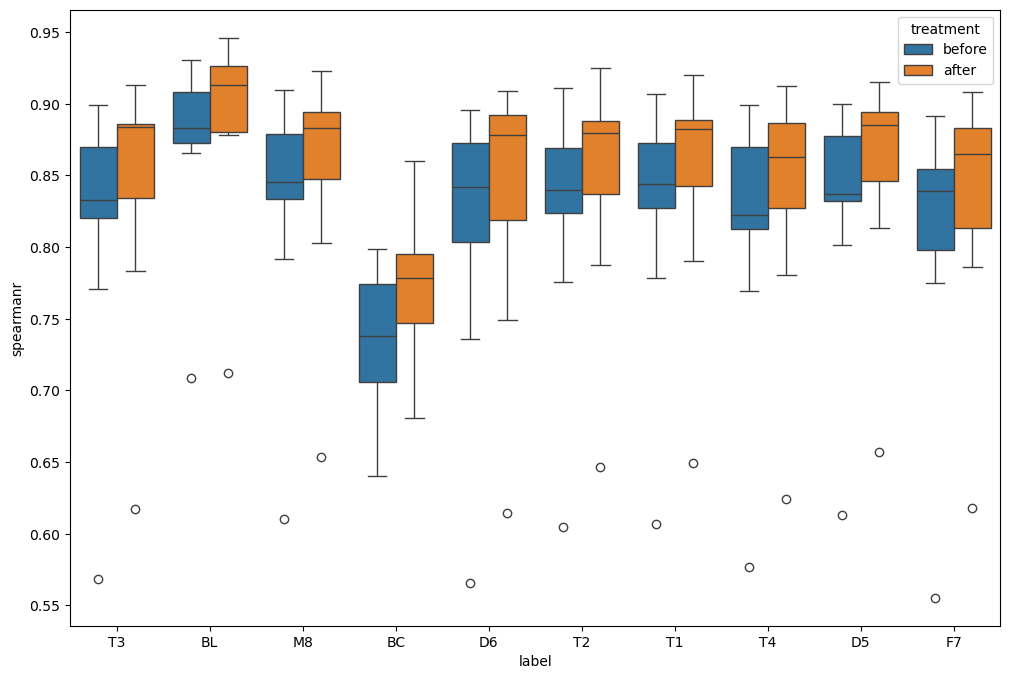

In [10]:
fig: Figure = plt.figure(figsize=(12, 8))
ax: Axes = (sns.boxplot(data=df.to_pandas(),
                        x='label', y='spearmanr', hue='treatment'))

<Axes: xlabel='PC1', ylabel='PC2'>

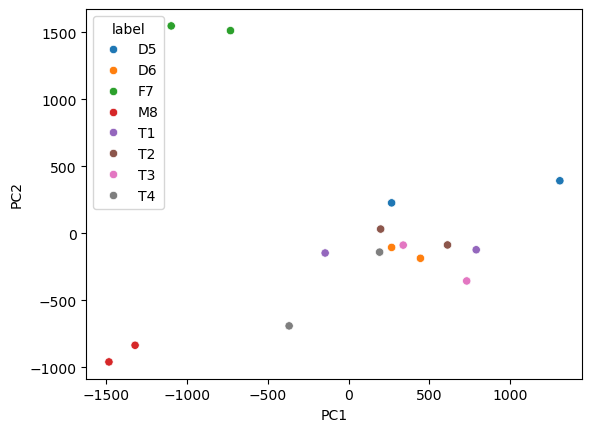

In [11]:
snr = pd.read_csv('/mnt/eqa/zhangyuanfeng/methylation/best_pipeline/data/evalutaed/after/c_snr/depth5/RR1.pcs.csv')
snr['label'] = snr['sample'].str.slice(stop=2)
sns.scatterplot(data=snr, x='PC1', y='PC2', hue='label')